In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import logging
logging.basicConfig(level=logging.ERROR)
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install transformers==2.8.0

     |████████████████████████████████| 573kB 8.9MB/s 
     |████████████████████████████████| 133kB 35.4MB/s 
     |████████████████████████████████| 901kB 33.5MB/s 
     |████████████████████████████████| 1.2MB 42.3MB/s 
     |████████████████████████████████| 5.6MB 23.6MB/s 
     |████████████████████████████████| 81kB 12.9MB/s 
     |████████████████████████████████| 7.7MB 42.9MB/s 
ERROR: botocore 1.20.104 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [4]:
!pip install tensorflow==1.13.1

     |████████████████████████████████| 92.6MB 114kB/s 
     |████████████████████████████████| 368kB 48.7MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 3.2MB 50.9MB/s 
ERROR: kapre 0.3.5 has requirement tensorflow>=2.0.0, but you'll have tensorflow 1.13.1 which is incompatible.
  Found existing installation: tensorflow-estimator 2.5.0
    Uninstalling tensorflow-estimator-2.5.0:
      Successfully uninstalled tensorflow-estimator-2.5.0
  Found existing installation: tensorboard 2.5.0
    Uninstalling tensorboard-2.5.0:
      Successfully uninstalled tensorboard-2.5.0
  Found existing installation: tensorflow 2.5.0
    Uninstalling tensorflow-2.5.0:
      Successfully uninstalled tensorflow-2.5.0


In [5]:
!cp -r "/content/drive/My Drive/research_lo_content_taxonomy_classification/model_euclidean_dual_bert_1_QC/" /content/
!cp -r "/content/drive/My Drive/research_lo_content_taxonomy_classification/model_euclidean_dual_bert_2_QC/" /content/

In [6]:
# !cp -r "/content/drive/My Drive/research_lo_content_taxonomy_classification/model_euclidean_dual_bert_1/" /content/
# !cp -r "/content/drive/My Drive/research_lo_content_taxonomy_classification/model_euclidean_dual_bert_2/" /content/

In [7]:
!pip install git+https://github.com/geoopt/geoopt.git
! pip install git+https://github.com/ferrine/hyrnn.git

  Cloning https://github.com/geoopt/geoopt.git to /tmp/pip-req-build-jfp0iwjf
  Running command git clone -q https://github.com/geoopt/geoopt.git /tmp/pip-req-build-jfp0iwjf
  Created wheel for geoopt: filename=geoopt-0.4.0rc1-cp37-none-any.whl size=85509 sha256=f2e1e30e0041d06250d0fdedfdfff7a963dd5149c04e7db6e485385543846a48
  Stored in directory: /tmp/pip-ephem-wheel-cache-dp_syl26/wheels/10/df/30/e0d857f034c142ca5f38af048b62aae3da773b272553e5dd21
Successfully built geoopt
  Cloning https://github.com/ferrine/hyrnn.git to /tmp/pip-req-build-8xs_uns3
  Running command git clone -q https://github.com/ferrine/hyrnn.git /tmp/pip-req-build-8xs_uns3
  Created wheel for hyrnn: filename=hyrnn-0.0.0-cp37-none-any.whl size=13969 sha256=85c32a39b5851c57fa52bdae1475c067853dab3e8386fedbd672d88dbc3eec72
  Stored in directory: /tmp/pip-ephem-wheel-cache-vqu4dmco/wheels/24/c3/64/cc0e9d25d466081dc154a2a8843157f54d845b916b4ba66418
Successfully built hyrnn


# Preparing data

In [8]:
import pandas as pd
train_data = pd.read_csv("train_QC_data.csv")
val_data = pd.read_csv("val_QC_data.csv")
test_data = pd.read_csv("test_QC_data.csv")

train_data


,questionID,originalQuestionID,totalPossiblePoint,AnswerKey,isMultipleChoiceQuestion,includesDiagram,examName,grade,year,QCLabel,Question,subject,category,fold
0,VASoL_2008_3_34,34,1,C,1,0,Virginia Standards of Learning - Science,3,2008,matter_properties of objects_TEXT,A student is asked to bring something that fee...,NaN,Train,Easy
1,MCAS_2015_8_6,6,1,B,1,0,MCAS,8,2015,celestial_FEATURES_STELLAR,Which of the following statements best describ...,NaN,Test,Easy
2,Mercury_SC_417677,417677,1,B,1,0,Mercury,4,2015,energy_LIGHT_REFLECT,A polished metal ball looks very shiny and bri...,NaN,Test,Challenge
3,Mercury_7230423,7230423,1,A,1,0,Mercury,9,2015,LIFE_EXTINCTION_MASSEX,Which was a main force driving extensive speci...,NaN,Test,Easy
4,NYSEDREGENTS_2007_8_6,6,1,2,1,0,NYSEDREGENTS,8,2007,Life_functions_features and functions_CELLBIO_...,Compared to the amount of hereditary informati...,NaN,Train,Challenge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5592,Mercury_402502,402502,1,D,1,0,Mercury,8,2015,matter_chemistry_periodic table,"According to the periodic table, argon is foun...",NaN,Test,Challenge
5593,MCAS_2006_9_20,20,1,B,1,0,MCAS,9,2006,FOR_MOMENTUM,Which of the following has the least momentum?...,NaN,Train,Challenge
5594,NYSEDREGENTS_2013_8_35,35,1,4,1,0,NYSEDREGENTS,8,2013,Life_functions_features and functions_PLANT_PH...,The amount of which greenhouse gas in the air ...,NaN,Test,Easy
5595,Mercury_7082670,7082670,1,C,1,0,Mercury,7,2015,energy_LIGHT_electromagnetic spectrum,The visible light spectrum can be subdivided a...,NaN,Test,Easy


In [9]:
test_data

,questionID,originalQuestionID,totalPossiblePoint,AnswerKey,isMultipleChoiceQuestion,includesDiagram,examName,grade,year,QCLabel,Question,subject,category,fold
0,Mercury_409529,409529,1,B,1,0,Mercury,7,2015,science_INFERENCE_experiment design,Robert is a fisherman who wants to find a way ...,NaN,Dev,Challenge
1,Mercury_7090790,7090790,1,A,1,0,Mercury,7,2015,matter_Change of state_EVAPoration,Which of these factors causes water to evapora...,NaN,Test,Challenge
2,TIMSS_2007_8_pg7,pg7,1,C,1,0,TIMSS,8,2007,matter_chemistry_atomic,Which statement is true about the particles of...,NaN,Train,Challenge
3,Mercury_7014455,7014455,1,A,1,0,Mercury,8,2015,energy_LIGHT_GENERICPROP,Which generates waves that are capable of trav...,NaN,Dev,Easy
4,NAEP_2000_8_S21+4,S21+4,1,C,1,0,NAEP,8,2000,forces and friction,To keep a heavy box sliding across a carpeted ...,NaN,Test,Challenge
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1395,Mercury_SC_401827,401827,1,D,1,0,Mercury,5,2015,matter_properties of material_ELECCOND,Metals that easily transfer electricity are ca...,NaN,Test,Easy
1396,MDSA_2010_5_35,35,1,C,1,0,Maryland School Assessment - Science,5,2010,EARTH_human impacts_WHAT_air pollution,Many states require vehicles to be examined an...,NaN,Train,Challenge
1397,Mercury_7024483,7024483,1,D,1,0,Mercury,8,2015,Life_reproduction_DNA inheritance_inheritance,Which of these is not an inherited trait in hu...,NaN,Train,Challenge
1398,NYSEDREGENTS_2008_4_17,17,1,D,1,0,NYSEDREGENTS,4,2008,Life_functions_FUNCT_animalESS,"In order to survive, all animals need (A) heat...",NaN,Test,Easy


In [10]:
from google.colab import files

In [11]:
import re
def clean_sentence(question):
  # print(question)
  question = re.sub('<[^>]*>', ' ',question)
  question = re.sub(' +', ' ', question)
  question = re.sub('\xa0','',question)
  question = question.rstrip()
  question = re.sub('nan','',question)
  question = re.sub(u'\u2004','',question)
  question = re.sub(u'\u2009','',question)

  # question = question.decode("utf-8")
  # question = question.replace(u'\u200\d*','').encode("utf-8")
  question = re.sub('&nbsp','',question)
  question = re.sub('&ndash','',question)
  question = re.sub('\r','',question)
  question = re.sub('\t','',question)
  question = re.sub('\n',' ',question)

  question = re.sub('MathType@.*','',question)
  question = re.sub('&thinsp','',question)
  question = re.sub('&times','',question)
  question = re.sub('\u200b','',question)
  question = re.sub('&rarr;;;','',question)

  return question

In [12]:
# final_data_1 = final_data.loc[0:71003,:]
# final_data_1

In [13]:
import transformers
print(transformers.__version__)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

2.8.0


In [14]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [15]:
train_data["QCLabel"].value_counts()

celestial_cycles                                                 106
matter_chemistry_periodic table                                   85
matter_chemistry_atomic                                           79
matter_CHANGES_CHEMICAL                                           72
science_INFERENCE_observation                                     69
                                                                ... 
matter_measurement_UNIT_TEMP                                       1
energy_LIGHT_SPEED                                                 1
EARTH_human impacts_RES_MINING                                     1
Life_functions_features and functions_CELLBIO_STRUCT_GOLGI         1
LIFE_environment and adaptation_animal adaptations_BEHAV_HUNT      1
Name: QCLabel, Length: 416, dtype: int64

In [16]:
test_data["QCLabel"].value_counts()

celestial_cycles                                          26
Life_reproduction_DNA inheritance_inheritance             26
Life_functions_features and functions_PLANT_PHOTOSYNTH    22
matter_chemistry_atomic                                   21
science_INFERENCE_experiment design                       19
                                                          ..
matter_properties of objects_TEMP                          1
celestial_ECLIPSE                                          1
LIFE_EXTINCTION_MASSEX                                     1
Life_cycle_GROWTH_DEF                                      1
LIFE_environment and adaptation_ADAP_animal                1
Name: QCLabel, Length: 352, dtype: int64

In [17]:

# from sklearn.preprocessing import LabelEncoder

# LE = LabelEncoder()
# final_data['label'] = LE.fit_transform(final_data['board_syllabus'])
# final_data.head()

In [18]:
# def get_labels(prediction):
#     predicted_label =  LE.inverse_transform([prediction])
#     return predicted_label[0]

In [19]:
# get_labels(330)

In [20]:
# train_data = pd.concat([train_data,val_data])
# train_data

In [21]:
train_features = train_data["Question"]
test_features = test_data["Question"]
train_labels = train_data["QCLabel"]
test_labels = test_data["QCLabel"]
val_features = val_data["Question"]
val_labels = val_data["QCLabel"]

In [22]:
train_labels.value_counts()

celestial_cycles                                                 106
matter_chemistry_periodic table                                   85
matter_chemistry_atomic                                           79
matter_CHANGES_CHEMICAL                                           72
science_INFERENCE_observation                                     69
                                                                ... 
matter_measurement_UNIT_TEMP                                       1
energy_LIGHT_SPEED                                                 1
EARTH_human impacts_RES_MINING                                     1
Life_functions_features and functions_CELLBIO_STRUCT_GOLGI         1
LIFE_environment and adaptation_animal adaptations_BEHAV_HUNT      1
Name: QCLabel, Length: 416, dtype: int64

In [23]:
test_labels.value_counts()

celestial_cycles                                          26
Life_reproduction_DNA inheritance_inheritance             26
Life_functions_features and functions_PLANT_PHOTOSYNTH    22
matter_chemistry_atomic                                   21
science_INFERENCE_experiment design                       19
                                                          ..
matter_properties of objects_TEMP                          1
celestial_ECLIPSE                                          1
LIFE_EXTINCTION_MASSEX                                     1
Life_cycle_GROWTH_DEF                                      1
LIFE_environment and adaptation_ADAP_animal                1
Name: QCLabel, Length: 352, dtype: int64

In [24]:

question_answer = train_features.values
categories = train_labels.values

In [25]:
question_answer

array(['A student is asked to bring something that feels rough to class. Which would be BEST for him to bring? (A) Pillow (B) Marble (C) Sandpaper (D) Trading card',
       'Which of the following statements best describes the role of gravity in the formation of stars? (A) Gravity converts solid matter into gases and light energy. (B) Gravity causes gases and dust particles to condense into spheres. (C) Gravity cools gases and liquids until they become one solid mass. (D) Gravity pushes rocks and dust particles outward from a dense center.',
       'A polished metal ball looks very shiny and bright on a sunny day. What makes the ball look shiny? (A) The ball makes light. (B) The ball reflects light. (C) The ball absorbs light and then releases it. (D) The ball absorbs light and keeps it inside.',
       ...,
       'The amount of which greenhouse gas in the air will increase the most if large forests are cut down to be used for building materials without planting new trees in their pla

In [26]:
categories

array(['matter_properties of objects_TEXT', 'celestial_FEATURES_STELLAR',
       'energy_LIGHT_REFLECT', ...,
       'Life_functions_features and functions_PLANT_PHOTOSYNTH',
       'energy_LIGHT_electromagnetic spectrum',
       'Life_reproduction_DNA inheritance_DOMRECESS'], dtype=object)

In [27]:
# val_features = test_features.values
# val_labels = test_labels.values

In [28]:
# list(set(label_emb_data))[0]
# # list(set(train_data['board_syllabus'].values))[0]
# label_emb_data[0]

In [29]:

import numpy as np
!pip install inflection

from bokeh.io import output_file, output_notebook, show
from bokeh.plotting import figure
from bokeh.transform import linear_cmap
from bokeh.util.hex import hexbin
from bokeh.models import HoverTool
from bokeh import colors
import inflection

from nltk.stem import PorterStemmer 
ps = PorterStemmer()
from gzip import open as gopen
from pandas.core.common import flatten
import gensim.models.poincare as poincare
def get_cleaned_taxonomy(taxonomy):
  cleaned_taxonomy = []
  for value in taxonomy:
      value = ' '.join(value.lower().split("_"))
      # taxonomy_words = [inflection.singularize(val)  for token in value for val in token.split(" ") if val.isalpha()]
      cleaned_taxonomy.append( value )
  return cleaned_taxonomy

In [30]:

# course_taxonomy

label_emb_data = get_cleaned_taxonomy(categories)
label_val = get_cleaned_taxonomy(val_labels)

In [31]:
label_emb_data[0]

'matter properties of objects text'

In [32]:
label_emb_data[2]

'energy light reflect'

In [33]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
wnl = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [34]:
len(list(set(label_emb_data)))

416

In [35]:
label_input_ids = []
label_attention_masks = []
for sent in label_emb_data:

    label_encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    label_input_ids.append(label_encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    label_attention_masks.append(label_encoded_dict['attention_mask'])
label_input_ids = torch.cat(label_input_ids, dim=0)
label_attention_masks = torch.cat(label_attention_masks, dim=0)

In [36]:
taxonomy_vectors = []
for label_input_id,label_att_mask in zip(label_input_ids,label_attention_masks):
    label_input_id = label_input_id.to(device)
    label_att_mask = label_att_mask.to(device)
    with torch.no_grad():
      outputs = model_label(label_input_id.reshape(1,-1),label_att_mask.reshape(1,-1))
    taxonomy_vectors.append(outputs.cpu().numpy())
taxonomy_vectors = np.vstack(taxonomy_vectors)
taxonomy_vectors.shape


NameError: ignored

In [ ]:
label_input_ids_val = []
label_attention_masks_val = []
for sent in label_val:

    label_encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    label_input_ids_val.append(label_encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    label_attention_masks_val.append(label_encoded_dict['attention_mask'])
label_input_ids_val = torch.cat(label_input_ids_val, dim=0)
label_attention_masks_val = torch.cat(label_attention_masks_val, dim=0)

In [ ]:
# taxonomy_vectors = []
# for label_input_id,label_att_mask in zip(label_input_ids,label_attention_masks):
#     label_input_id = label_input_id.to(device)
#     label_att_mask = label_att_mask.to(device)
#     with torch.no_grad():
#       outputs = model_label(label_input_id.reshape(1,-1),label_att_mask.reshape(1,-1))
#     taxonomy_vectors.append(outputs[1].cpu().numpy())
# taxonomy_vectors = np.vstack(taxonomy_vectors)
# taxonomy_vectors.shape


In [ ]:
# taxonomy_vectors_val = []
# for feature in poincare_val:
#   taxonomy_vectors_val.append(model.embed_sentences([feature]))
# taxonomy_vectors_val = np.vstack(taxonomy_vectors_val)
# taxonomy_vectors_val.shape

In [ ]:
test_data

In [ ]:
# np.array(poincare_embedding).shape

In [ ]:
input_ids = []
attention_masks = []

for sent in question_answer:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)


# Print sentence 0, now as a list of IDs.
print('Original: ', question_answer[0])
print('Token IDs:', input_ids[0])

In [ ]:
input_ids_val = []
attention_masks_val = []

for sent in val_features:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids_val.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks_val.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids_val = torch.cat(input_ids_val, dim=0)
attention_masks_val = torch.cat(attention_masks_val, dim=0)


# Print sentence 0, now as a list of IDs.
print('Original: ', question_answer[0])
print('Token IDs:', input_ids[0])

In [ ]:
num_classes = len(list(set(categories)))
num_classes

In [ ]:
from torch.utils.data import TensorDataset, random_split
# train_poincare_tensor = torch.tensor(taxonomy_vectors,dtype=torch.float)
# val_poincare_tensor = torch.tensor(taxonomy_vectors_val,dtype=torch.float)

val_dataset = TensorDataset(input_ids_val,attention_masks_val,label_input_ids_val,label_attention_masks_val)
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset(input_ids, attention_masks, label_input_ids,label_attention_masks)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
batch_size = 32
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In [ ]:
# !pip install transformers==2.8.0
import transformers
print(transformers.__version__)

In [ ]:
set(question_answer).intersection(set(test_features))

In [37]:

import sys
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import pyplot as plt
from torch.nn.modules.loss import HingeEmbeddingLoss
from random import randint

from tqdm import tqdm
import geoopt
import time
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import pyplot as plt
from torch.nn.modules.loss import HingeEmbeddingLoss
from random import randint
import torch.nn.functional as F

import time
import argparse
cos = nn.CosineSimilarity(dim=0, eps=1e-6)
# Neural Classifierwork
class MulticlassClassifier(nn.Module):
    def __init__(self,bert_model_path):
        super(MulticlassClassifier,self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_path,output_hidden_states=False,output_attentions=False)
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(768, 384)
        self.fc2 = nn.Linear(384, 768)

    def forward(self,tokens,masks):
        _, pooled_output = self.bert(tokens, attention_mask=masks)
        x = self.fc1(pooled_output)
        x = self.fc2(x)
        return x
class MyHingeLoss(torch.nn.Module):
    def __init__(self, margin):
        super(MyHingeLoss, self).__init__()
        self.margin = margin
    # def forward_val(self, output, target):
    #     cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    #     loss = 0
    #     num_compare = 4
    #     count = 0
    #     for i in range(len(output)):
    #         v_image = output[i]
    #         t_label = target[i]
    #         for j in range(num_compare):
    #             if j != i:
    #                 count += 1
    #                 t_j = target[j]
    #                 loss += torch.relu( self.margin - cos(t_label, v_image) + cos(t_j, v_image) )
    #     return loss / count

    def forward(self, output, target):
        loss=0
        for i in range(len(output)):
            v_image = output[i]
            t_label = target[i]
            j = randint(0, len(output)-1)
            while j == i:
                j = randint(0, len(output)-1)
            t_j = target[j]
            loss+= torch.relu( self.margin - cos(t_label, v_image) + cos(t_j, v_image) )
        return loss / len(output)


In [38]:
from transformers import BertModel, AdamW, BertConfig
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


# Training


In [ ]:
from transformers import BertModel, AdamW, BertConfig

# Loads BertModel, the pretrained BERT model with a single 
model = MulticlassClassifier('bert-base-uncased')
# model.load_state_dict(torch.load('model_euclidean_dual_bert_1/model_weights'))
model_label = MulticlassClassifier('bert-base-uncased')
# Tell pytorch to run this model on the GPU.
# model_label.load_state_dict(torch.load('model_euclidean_dual_bert_2/model_weights'))

model.cuda()
model_label.cuda()

In [ ]:
# mobius_params = []
# bert_params = []

# def mobius_params():
#   for param in model.named_parameters():
#     if 'fc' in param[0]:
#       yield param[1]
# def bert_params():
#   for param in model.named_parameters():
#     if 'bert' in param[0]:
#       yield param[1]


In [ ]:
optimizer_1 = torch.optim.AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
optimizer_2 = torch.optim.AdamW(model_label.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup


epochs = 30

# Total number of training steps is [number of batches] x [number of epochs]. 
total_steps = len(train_dataloader) * epochs



In [ ]:
len(train_dataloader) 

In [ ]:
1935 * 32

In [ ]:
scheduler = get_linear_schedule_with_warmup(optimizer_1, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
# import numpy as np

# # Function to calculate the accuracy of our predictions vs labels
# def flat_accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
criterion = MyHingeLoss(0.1)


In [ ]:
import random
import numpy as np
import json
from sklearn.metrics import f1_score
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()
early_stopping = EarlyStopping(patience=6, verbose=True)

# For each epoch...
for epoch_i in range(0, epochs):
    


    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0


    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))


        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_label_input_ids = batch[2].to(device)
        b_label_att_masks = batch[3].to(device)


        model.zero_grad() 
        model_label.zero_grad()
        optimizer_1.zero_grad()       

        logits = model(b_input_ids, 
                             b_input_mask)
        label_repr = model_label(b_label_input_ids,b_label_att_masks)
        
        loss = criterion.forward(logits,label_repr)

  
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer_1.step()
        optimizer_2.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_f1 = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_label_input_id = batch[2].to(device)
        b_label_att_mask = batch[3].to(device)

        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        


          logits = model(b_input_ids, 
                              b_input_mask)
          label_repr = model_label(b_label_input_id,b_label_att_mask)
        loss = criterion(logits,label_repr)

            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        # Move logits and labels to CPU
        # logits = logits.detach().cpu().numpy().round()
        # label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        # total_eval_f1 += f1_score(label_ids,logits, average='macro')
        

    # Report the final accuracy for this validation run.
    # avg_val_accuracy = total_eval_f1 / len(validation_dataloader)
    # print("  f1score: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break  
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    output_dir = 'model_euclidean_dual_bert_1_QC/'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
        os.makedirs("model_euclidean_dual_bert_2_QC")

    print("Saving model to %s" % output_dir)
    tokenizer.save_pretrained(output_dir)
    torch.save(model.state_dict(), os.path.join(output_dir, 'model_weights'))
    torch.save(model_label.state_dict(), os.path.join('model_euclidean_dual_bert_2_QC', 'model_weights'))


    !rm -rf "/content/drive/My Drive/research_lo_content_taxonomy_classification/model_euclidean_dual_bert_1_QC"
    !mv model_euclidean_dual_bert_1_QC "/content/drive/My Drive/research_lo_content_taxonomy_classification/"

    !rm -rf "/content/drive/My Drive/research_lo_content_taxonomy_classification/model_euclidean_dual_bert_2_QC"
    !mv model_euclidean_dual_bert_2_QC "/content/drive/My Drive/research_lo_content_taxonomy_classification/"
    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 30 ========
Training...
  Batch    40  of    175.    Elapsed: 0:00:57.
  Batch    80  of    175.    Elapsed: 0:01:55.
  Batch   120  of    175.    Elapsed: 0:02:55.
  Batch   160  of    175.    Elapsed: 0:03:55.

  Average training loss: 0.06
  Training epcoh took: 0:04:18

Running Validation...
Validation loss decreased (inf --> 0.033130).  Saving model ...
  Validation Loss: 0.03
  Validation took: 0:00:14
Saving model to model_euclidean_dual_bert_1_QC/

======== Epoch 2 / 30 ========
Training...
  Batch    40  of    175.    Elapsed: 0:01:01.
  Batch    80  of    175.    Elapsed: 0:02:02.
  Batch   120  of    175.    Elapsed: 0:03:02.
  Batch   160  of    175.    Elapsed: 0:04:02.

  Average training loss: 0.03
  Training epcoh took: 0:04:25

Running Validation...
Validation loss decreased (0.033130 --> 0.025771).  Saving model ...
  Validation Loss: 0.03
  Validation took: 0:00:14
Saving model to model_euclidean_dual_bert_1_QC/

======== Epoch 3 / 30 ========
Tra

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,6.09e-02,0.03,0:04:18,0:00:14
2,3.02e-02,0.03,0:04:25,0:00:14
3,2.40e-02,0.02,0:04:25,0:00:14
4,2.30e-02,0.02,0:04:25,0:00:12
5,1.82e-02,0.02,0:04:24,0:00:12
6,1.59e-02,0.03,0:04:24,0:00:12
7,1.38e-02,0.02,0:04:23,0:00:12
8,1.34e-02,0.02,0:04:23,0:00:12
9,1.24e-02,0.02,0:04:23,0:00:14


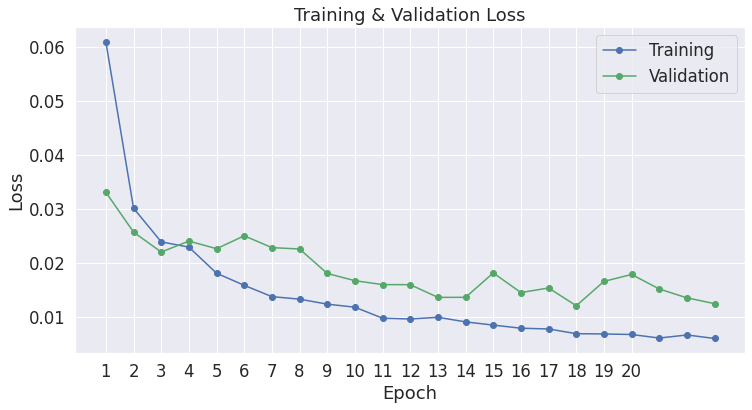

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

plt.show()

In [ ]:
import os


output_dir = 'model_euclidean_dual_bert_1_QC_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)


# model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to model_euclidean_dual_bert_1_QC_save/


('model_euclidean_dual_bert_1_QC_save/vocab.txt',
 'model_euclidean_dual_bert_1_QC_save/special_tokens_map.json',
 'model_euclidean_dual_bert_1_QC_save/added_tokens.json')

In [ ]:
# !pip install joblib
# import joblib
# joblib.dump(LE, "label_encoder")


In [ ]:
import json
torch.save(model.state_dict(), os.path.join(output_dir, 'model_weights'))


In [ ]:
!mv /content/model_euclidean_dual_bert_1_QC_save "/content/drive/My Drive/research_lo_content_taxonomy_classification"

In [ ]:
# with open(os.path.join(output_dir, 'model_config.json'), 'w') as f:
#     json.dump(model.config, f)

In [ ]:
!zip -r model_euclidean_cos.zip model_euclidean_cos
# files.download('model_euclidean_1.zip')

  adding: model_euclidean_cos/ (stored 0%)
  adding: model_euclidean_cos/model_weights (deflated 7%)
  adding: model_euclidean_cos/vocab.txt (deflated 53%)
  adding: model_euclidean_cos/special_tokens_map.json (deflated 40%)
  adding: model_euclidean_cos/tokenizer_config.json (stored 0%)


In [ ]:
# !zip -r label_encoder_categorized_reduced.zip label_encoder
# files.download('label_encoder_categorized_reduced.zip')

# Inference

In [50]:
from transformers import BertModel, AdamW, BertConfig

# Loads BertModel, the pretrained BERT model with a single 
model = MulticlassClassifier('bert-base-uncased')
model.load_state_dict(torch.load('model_euclidean_dual_bert_1_QC/model_weights'))
model_label = MulticlassClassifier('bert-base-uncased')
# Tell pytorch to run this model on the GPU.
model_label.load_state_dict(torch.load('model_euclidean_dual_bert_2_QC/model_weights'))

model.cuda()
model_label.cuda()

MulticlassClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

In [ ]:
# run only for LO inference. Else skip this cell and next
import pandas as pd
lo_data = pd.read_csv("what_you_learnt_lo_labelled.csv", delimiter="|")

In [ ]:
test_features = lo_data["learning_objectives"].values
labels = lo_data["taxonomy"].values

In [39]:
test_features = test_features.values
labels = test_labels.values

In [40]:
test_features

array(["Robert is a fisherman who wants to find a way to catch more fish. He decided to try different sizes of hooks. Robert caught 4 catfish, 3 trout, and 7 perch while using worms for bait. Which is the independent (manipulated) variable in Robert's investigation? (A) type of bait (B) size of hook (C) type of fish caught (D) number of fish caught",
       'Which of these factors causes water to evaporate the fastest? (A) high temperatures (B) high humidity (C) slow winds (D) slow runoff',
       'Which statement is true about the particles of a liquid compared to the particles of a gas? (A) Particles of a liquid are a slower and further apart. (B) Particles of a liquid are faster and farther apart. (C) Particles of a liquid are slower and closer together. (D) Particles of a liquid are faster and closer together.',
       ...,
       'Which of these is not an inherited trait in humans? (A) height (B) hair color (C) skin color (D) intelligence',
       'In order to survive, all animals

In [41]:
len(list(set(labels)))

352

In [42]:
def get_cleaned_taxonomy_lo(taxonomy):
  cleaned_taxonomy = []
  for value in taxonomy:
      value = ' '.join(value.lower().split(">>"))
      # taxonomy_words = [inflection.singularize(val)  for token in value for val in token.split(" ") if val.isalpha()]
      cleaned_taxonomy.append( value )
  return cleaned_taxonomy

In [ ]:
# Execute only for LO
test_labels = list(set(labels))
test_set_labels = get_cleaned_taxonomy_lo(test_labels)
test_set_labels[0]

'science cell structure and functions'

In [113]:
import pandas as pd
targets = pd.read_csv("targets_ARC.csv")
targets = targets["targets"].values

In [114]:
cleaned_targets = get_cleaned_taxonomy(targets)
cleaned_targets[0]

'life environment and adaptation animal adaptations behav nestbldg'

In [115]:
cleaned_targets[0]

'life environment and adaptation animal adaptations behav nestbldg'

In [116]:
label_input_ids = []
label_attention_masks = []
for sent in cleaned_targets:

    label_encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    label_input_ids.append(label_encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    label_attention_masks.append(label_encoded_dict['attention_mask'])
label_input_ids = torch.cat(label_input_ids, dim=0)
label_attention_masks = torch.cat(label_attention_masks, dim=0)

In [117]:
taxonomy_vectors = []
for label_input_id,label_att_mask in zip(label_input_ids,label_attention_masks):
    label_input_id = label_input_id.to(device)
    label_att_mask = label_att_mask.to(device)
    with torch.no_grad():
      outputs = model_label(label_input_id.reshape(1,-1),label_att_mask.reshape(1,-1))
    taxonomy_vectors.append(outputs.cpu().numpy())
taxonomy_vectors = np.vstack(taxonomy_vectors)
taxonomy_vectors.shape


(352, 768)

In [118]:
# model = MulticlassClassifier('bert-base-uncased')
# # model.load_state_dict(torch.load('model_euclidean_cos/model_weights'))
# model.cuda()

In [119]:
test_input_ids = []
test_attention_masks = []
for sent in test_features:

    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        truncation=True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    test_input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    test_attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
test_input_ids = torch.cat(test_input_ids, dim=0)
test_attention_masks = torch.cat(test_attention_masks, dim=0)
# labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  
test_poincare_tensor = torch.tensor(taxonomy_vectors,dtype=torch.float)

# Create the DataLoader.
# prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_poincare_tensor)
# prediction_sampler = SequentialSampler(prediction_data)
# prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [120]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
test_poincare_tensor = torch.tensor(taxonomy_vectors,dtype=torch.float)


In [121]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
def dist_without_grad( u, v):
  sqdist = torch.sum((u - v) ** 2, dim=-1)
  squnorm = torch.sum(u ** 2, dim=-1)
  sqvnorm = torch.sum(v ** 2, dim=-1)
  x = 1 + 2 * sqdist / ((1 - squnorm) * (1 - sqvnorm)) + 1e-7
  z = torch.sqrt(x ** 2 - 1)
  return torch.log(x + z)

In [122]:
len(labels)

352

In [123]:
targets = np.array(targets)

In [124]:
def precision(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    return result

def recall(actual, predicted, k):
    act_set = set(actual)
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(len(act_set))
    return result

In [125]:
test_poincare_tensor.shape

torch.Size([352, 768])

In [126]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

# Put model in evaluation mode
model.eval()
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)

input_ids = test_input_ids.to('cuda')
attention_masks = test_attention_masks.to('cuda')
test_poincare_tensor = test_poincare_tensor.to('cuda')
# Tracking variables 
predictions , true_labels = [], []
for input_id,attention_mask in zip(input_ids, attention_masks):
  with torch.no_grad():
    outputs = model(input_id.reshape(1,-1),attention_mask.reshape(1,-1))
    
  distances = cos(outputs,test_poincare_tensor) #torch.topk(cos(outputs,test_poincare_tensor),20,largest=True)
  distances,indices = torch.topk(distances,10,largest=True)
  predictions.append(targets[indices.cpu().numpy()])
print(len(predictions))
print('    DONE.')
# predictions

Predicting labels for 1,400 test sentences...
1400
    DONE.


In [127]:
targets = pd.read_csv("targets_ARC.csv")

labels = targets["targets"].values

In [128]:
from sklearn .preprocessing import LabelEncoder
LE= LabelEncoder()
labels = LE.fit_transform(labels)
labels

array([107, 168,  77, 183, 281, 254, 142, 249,  81, 103, 312, 299, 171,
       337, 179, 208, 285, 155, 335, 342, 137, 243, 188,  69, 217, 273,
        16, 344,  88, 316, 132,  85, 118,  20, 244, 125, 348, 332, 164,
       280,  33, 256, 251, 100, 216, 278, 279, 287,   3, 204,  71, 269,
       334, 196,  72, 158,   7, 172, 173, 325, 297,  11, 295, 195, 180,
        89, 308,  48, 274,  43, 264, 139, 104, 230,  95, 241, 154, 231,
        37,  87, 229, 145,  75, 190, 286, 234, 101,  51, 199,  68, 283,
        29, 112, 326, 184, 296, 162, 189, 343, 303,  82, 201, 122,  73,
       108, 141,   6,  14, 257,  97, 330, 111,  39, 175, 213, 300,  67,
       311, 255, 152, 338, 349,  46, 130, 347, 177, 176, 320, 246, 220,
         1, 110, 121, 271, 277, 282,  53, 310, 322, 319, 307, 170,  98,
       167, 236, 309, 346, 131,  25, 209, 315,  49, 293,  52, 259, 106,
       181, 268, 267, 197, 126,  38,  34, 317,  83, 219, 266, 265, 245,
        94, 305, 324, 124, 105,  22,   2, 214, 146, 260,  80, 13

In [129]:
LE.inverse_transform([325])

array(['matter_properties of material_REFLECT'], dtype=object)

In [65]:
labels

array(['science_INFERENCE_experiment design',
       'matter_Change of state_EVAPoration', 'matter_chemistry_atomic',
       ..., 'Life_reproduction_DNA inheritance_inheritance',
       'Life_functions_FUNCT_animalESS', 'EARTH_INNER_PLATE_CONTDRIFT'],
      dtype=object)

In [ ]:
np.where(labels==325)

(array([], dtype=int64),)

In [ ]:
LE.transform(["matter_properties of material_REFLECT"])

array([325])

In [ ]:
#unseen label proof

np.where(test_data["QCLabel"].values=="matter_properties of material_REFLECT")

(array([ 498,  644, 1102]),)

In [ ]:
#unseen label proof

LE.inverse_transform([325])

array(['matter_properties of material_REFLECT'], dtype=object)

In [ ]:
LE.inverse_transform([320])

array(['matter_properties of material_FLEX'], dtype=object)

In [ ]:
LE.inverse_transform([331])

array(['matter_properties of objects_MASS'], dtype=object)

In [ ]:
LE.inverse_transform([330])

array(['matter_properties of objects_DENSITY'], dtype=object)

In [ ]:
LE.inverse_transform([265])

array(['energy_thermal conductivity_RADIATION'], dtype=object)

In [ ]:
LE.inverse_transform([245])

array(['energy_LIGHT_GENERICPROP'], dtype=object)

In [130]:
final_predictions = []
for prediction in predictions:
  final_predictions.append(LE.transform(prediction))


In [131]:
test_labels = LE.transform(test_data["QCLabel"].values)

In [ ]:
#unseen label proof
final_predictions[1102]


array([331, 330, 243, 332, 247, 271, 286, 329, 244, 273])

In [ ]:
final_predictions[498]


array([297,  12,  10, 294, 318, 301, 275, 321, 330,  11])

In [ ]:
final_predictions[644]


array([265, 245, 264, 248, 247, 243, 254, 234, 252, 250])

In [ ]:
final_predictions[-3]

array([35])

In [ ]:
y_true

<tf.Tensor 'Identity_44:0' shape=(2664,) dtype=int64>

In [ ]:
import tensorflow as tf
y_true = np.array(labels)
y_true = tf.identity(y_true)
y_pred = np.array(final_predictions)
y_pred = tf.identity(y_pred)
print(y_pred.shape,y_true.shape)
k = 20
recall, update_recall = tf.compat.v1.metrics.recall_at_top_k(y_true, y_pred, k=20)
precision, update_precision = tf.compat.v1.metrics.precision_at_top_k(y_true, y_pred, k=20)

tmp_rank = tf.nn.top_k(y_pred, 20)
stream_vars = [i for i in tf.local_variables()]

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    # print("precision",sess.run(update_precision))
    # print("precision",s|ess.run(precision))

    print("update_recall: ",sess.run(update_recall ))
    print("recall",sess.run(recall))

    print("STREAM_VARS: ",(sess.run(stream_vars)))
    print("TMP_RANK: ",sess.run(tmp_rank))

(1400, 20) (1400,)
update_recall:  0.7828571428571428
recall 0.7828571428571428
STREAM_VARS:  [0.0, 0.0, 0.0, 0.0, 1096.0, 304.0, 0.0, 0.0]
TMP_RANK:  TopKV2(values=array([[350, 349, 348, ..., 194, 192,  96],
       [284, 283, 282, ...,  30,  29,  27],
       [315, 314, 313, ...,  80,  79,  77],
       ...,
       [350, 348, 335, ...,  91,  90,  87],
       [141, 140, 139, ...,  99,  97,  95],
       [351, 350, 348, ...,   5,   2,   1]]), indices=array([[ 0,  7,  1, ..., 17, 19, 16],
       [14, 18, 11, ...,  3, 13, 16],
       [ 5,  4, 14, ..., 11,  8, 12],
       ...,
       [14, 19, 15, ...,  8, 16,  3],
       [16, 18, 15, ...,  7,  6, 19],
       [ 6,  7, 13, ..., 19, 10, 12]], dtype=int32))


In [ ]:
import tensorflow as tf
y_true = np.array(labels)
y_true = tf.identity(y_true)
y_pred = np.array(final_predictions)
y_pred = tf.identity(y_pred)
print(y_pred.shape,y_true.shape)
k = 8
recall, update_recall = tf.compat.v1.metrics.recall_at_top_k(y_true, y_pred, 15)
precision, update_precision = tf.compat.v1.metrics.precision_at_top_k(y_true, y_pred, 15)

tmp_rank = tf.nn.top_k(y_pred, 15)
stream_vars = [i for i in tf.local_variables()]

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    print("precision",sess.run(update_precision))
    # print("precision",sess.run(precision))

    print("update_recall: ",sess.run(update_recall ))
    print("recall",sess.run(recall))

    print("STREAM_VARS: ",(sess.run(stream_vars)))
    print("TMP_RANK: ",sess.run(tmp_rank))

(1400, 15) (1400,)
precision 0.04766666666666667
update_recall:  0.715
recall 0.715
STREAM_VARS:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1001.0, 399.0, 1001.0, 19999.0]
TMP_RANK:  TopKV2(values=array([[350, 349, 348, ..., 337, 336, 335],
       [284, 282, 281, ...,  31,  30,  29],
       [315, 314, 313, ...,  80,  79,  77],
       ...,
       [350, 195, 194, ...,  96,  91,  87],
       [137, 134, 132, ..., 101,  99,  97],
       [351, 350, 348, ...,   6,   2,   1]]), indices=array([[ 0,  7,  1, ...,  4,  6, 13],
       [14, 11,  7, ...,  1,  3, 13],
       [ 5,  4, 14, ..., 11,  8, 12],
       ...,
       [14,  1,  5, ..., 12,  8,  3],
       [ 0,  4, 10, ..., 14,  7,  6],
       [ 6,  7, 13, ...,  2, 10, 12]], dtype=int32))


In [ ]:
import tensorflow as tf
y_true = np.array(labels)
y_true = tf.identity(y_true)
y_pred = np.array(final_predictions)
y_pred = tf.identity(y_pred)
print(y_pred.shape,y_true.shape)
k = 8
recall, update_recall = tf.compat.v1.metrics.recall_at_top_k(y_true, y_pred, 10)
precision, update_precision = tf.compat.v1.metrics.precision_at_top_k(y_true, y_pred, 10)

tmp_rank = tf.nn.top_k(y_pred, 10)
stream_vars = [i for i in tf.local_variables()]

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    print("precision",sess.run(update_precision))
    # print("precision",sess.run(precision))

    print("update_recall: ",sess.run(update_recall ))
    print("recall",sess.run(recall))

    print("STREAM_VARS: ",(sess.run(stream_vars)))
    print("TMP_RANK: ",sess.run(y_pred))

(1400, 10) (1400,)
precision 0.06342857142857143
update_recall:  0.6342857142857142
recall 0.6342857142857142
STREAM_VARS:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 888.0, 512.0, 888.0, 13112.0]
TMP_RANK:  [[350 348 339 ... 349 346 342]
 [ 45  31  55 ... 281  44 280]
 [270 309 262 ... 311  79 307]
 ...
 [192 195 190 ... 193  91 188]
 [137 120 118 ...  99 117 126]
 [  9   7   6 ... 350 346  88]]


In [ ]:
import tensorflow as tf
y_true = np.array(labels)
y_true = tf.identity(y_true)
y_pred = np.array(final_predictions)
y_pred = tf.identity(y_pred)
print(y_pred.shape,y_true.shape)
k = 8
recall, update_recall = tf.compat.v1.metrics.recall_at_top_k(y_true, y_pred, 10)
precision, update_precision = tf.compat.v1.metrics.precision_at_top_k(y_true, y_pred, 10)

tmp_rank = tf.nn.top_k(y_pred, 10)
stream_vars = [i for i in tf.local_variables()]

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    print("precision",sess.run(update_precision))
    # print("precision",sess.run(precision))

    print("update_recall: ",sess.run(update_recall ))
    print("recall",sess.run(recall))

    print("STREAM_VARS: ",(sess.run(stream_vars)))
    print("TMP_RANK: ",sess.run(y_pred))

(1400, 10) (1400,)
precision 0.061785714285714284
update_recall:  0.6178571428571429
recall 0.6178571428571429
STREAM_VARS:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 865.0, 535.0, 865.0, 13135.0]
TMP_RANK:  [[350 346 349 ... 337 345 344]
 [ 45  55  63 ...  48  72  57]
 [272 244 273 ... 247 268 267]
 ...
 [192 195 194 ... 188 191  87]
 [134 118  99 ... 133 132 131]
 [  6   7   8 ...  15   1  26]]


In [ ]:
import tensorflow as tf
y_true = np.array(labels)
y_true = tf.identity(y_true)
y_pred = np.array(final_predictions)
y_pred = tf.identity(y_pred)
print(y_pred.shape,y_true.shape)
k = 8
recall, update_recall = tf.compat.v1.metrics.recall_at_top_k(y_true, y_pred, 5)
precision, update_precision = tf.compat.v1.metrics.precision_at_top_k(y_true, y_pred, 5)

tmp_rank = tf.nn.top_k(y_pred, 5)
stream_vars = [i for i in tf.local_variables()]

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    print("precision",sess.run(update_precision))
    # print("precision",sess.run(precision))

    print("update_recall: ",sess.run(update_recall ))
    print("recall",sess.run(recall))

    print("STREAM_VARS: ",(sess.run(stream_vars)))
    print("TMP_RANK: ",sess.run(tmp_rank))

(1400, 5) (1400,)
precision 0.09157142857142857
update_recall:  0.45785714285714285
recall 0.45785714285714285
STREAM_VARS:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 641.0, 759.0, 641.0, 6359.0]
TMP_RANK:  TopKV2(values=array([[350, 348, 343, 339, 337],
       [ 60,  55,  45,  31,  30],
       [314, 309, 306, 270, 262],
       ...,
       [195, 192, 190, 189,  87],
       [137, 134, 121, 120, 118],
       [ 86,   9,   8,   7,   6]]), indices=array([[0, 1, 3, 2, 4],
       [4, 2, 0, 1, 3],
       [4, 1, 3, 0, 2],
       ...,
       [1, 0, 2, 4, 3],
       [0, 4, 3, 1, 2],
       [3, 0, 4, 1, 2]], dtype=int32))


In [ ]:
import tensorflow as tf
y_true = np.array(labels)
y_true = tf.identity(y_true)
y_pred = np.array(final_predictions)
y_pred = tf.identity(y_pred)
print(y_pred.shape,y_true.shape)
k = 8
recall, update_recall = tf.compat.v1.metrics.recall_at_top_k(y_true, y_pred, 5)
precision, update_precision = tf.compat.v1.metrics.precision_at_top_k(y_true, y_pred, 5)

tmp_rank = tf.nn.top_k(y_pred, 5)
stream_vars = [i for i in tf.local_variables()]

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    print("precision",sess.run(update_precision))
    # print("precision",sess.run(precision))

    print("update_recall: ",sess.run(update_recall ))
    print("recall",sess.run(recall))

    print("STREAM_VARS: ",(sess.run(stream_vars)))
    print("TMP_RANK: ",sess.run(tmp_rank))

(1400, 5) (1400,)
precision 0.08442857142857142
update_recall:  0.42214285714285715
recall 0.42214285714285715
STREAM_VARS:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 591.0, 809.0, 591.0, 6409.0]
TMP_RANK:  TopKV2(values=array([[350, 349, 348, 346, 343],
       [ 63,  60,  58,  55,  45],
       [273, 272, 271, 246, 244],
       ...,
       [195, 194, 192, 190, 189],
       [135, 134, 121, 118,  99],
       [  9,   8,   7,   6,   2]]), indices=array([[0, 2, 3, 1, 4],
       [2, 4, 3, 1, 0],
       [2, 0, 4, 3, 1],
       ...,
       [1, 2, 0, 4, 3],
       [4, 0, 3, 1, 2],
       [3, 2, 1, 0, 4]], dtype=int32))


In [ ]:
import tensorflow as tf
y_true = np.array(labels)
y_true = tf.identity(y_true)
y_pred = np.array(final_predictions)
y_pred = tf.identity(y_pred)
print(y_pred.shape,y_true.shape)
k = 8
recall, update_recall = tf.compat.v1.metrics.recall_at_top_k(y_true, y_pred, 1)
precision, update_precision = tf.compat.v1.metrics.precision_at_top_k(y_true, y_pred, 1)

tmp_rank = tf.nn.top_k(y_pred, 1)
stream_vars = [i for i in tf.local_variables()]

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    print("precision",sess.run(update_precision))
    # print("precision",sess.run(precision))

    print("update_recall: ",sess.run(update_recall ))
    print("recall",sess.run(recall))

    print("STREAM_VARS: ",(sess.run(stream_vars)))
    print("TMP_RANK: ",sess.run(tmp_rank))

(4784, 1) (4784,)
precision 0.4280936454849498
update_recall:  0.4280936454849498
recall 0.4280936454849498
STREAM_VARS:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2048.0, 2736.0, 2048.0, 2736.0]
TMP_RANK:  TopKV2(values=array([[ 66],
       [176],
       [116],
       ...,
       [ 49],
       [  8],
       [152]]), indices=array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]], dtype=int32))


#### LO classification o/p

In [ ]:
import tensorflow as tf
y_true = np.array(labels)
y_true = tf.identity(y_true)
y_pred = np.array(final_predictions)
y_pred = tf.identity(y_pred)
print(y_pred.shape,y_true.shape)
k = 8
recall, update_recall = tf.compat.v1.metrics.recall_at_top_k(y_true, y_pred, 1)
precision, update_precision = tf.compat.v1.metrics.precision_at_top_k(y_true, y_pred, 1)

tmp_rank = tf.nn.top_k(y_pred, 1)
stream_vars = [i for i in tf.local_variables()]

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    print("precision",sess.run(update_precision))
    # print("precision",sess.run(precision))

    print("update_recall: ",sess.run(update_recall ))
    print("recall",sess.run(recall))

    print("STREAM_VARS: ",(sess.run(stream_vars)))
    print("TMP_RANK: ",sess.run(tmp_rank))

(417, 1) (417,)
precision 0.539568345323741
update_recall:  0.539568345323741
recall 0.539568345323741
STREAM_VARS:  [225.0, 192.0, 225.0, 192.0]
TMP_RANK:  TopKV2(values=array([[ 5],
       [ 1],
       [21],
       [21],
       [39],
       [28],
       [28],
       [21],
       [ 1],
       [ 5],
       [ 1],
       [28],
       [ 0],
       [ 5],
       [ 5],
       [ 4],
       [ 5],
       [ 0],
       [28],
       [27],
       [29],
       [27],
       [29],
       [27],
       [29],
       [29],
       [27],
       [29],
       [ 6],
       [27],
       [21],
       [34],
       [29],
       [29],
       [ 0],
       [ 1],
       [34],
       [ 5],
       [ 2],
       [ 7],
       [ 0],
       [ 0],
       [41],
       [41],
       [34],
       [41],
       [ 9],
       [22],
       [30],
       [30],
       [22],
       [22],
       [22],
       [22],
       [22],
       [22],
       [11],
       [ 9],
       [ 9],
       [ 9],
       [ 9],
       [ 3],
       [ 9],
       [ 9

In [ ]:
import tensorflow as tf
y_true = np.array(labels)
y_true = tf.identity(y_true)
y_pred = np.array(final_predictions)
y_pred = tf.identity(y_pred)
print(y_pred.shape,y_true.shape)
k = 8
recall, update_recall = tf.compat.v1.metrics.recall_at_top_k(y_true, y_pred, 2)
precision, update_precision = tf.compat.v1.metrics.precision_at_top_k(y_true, y_pred, 2)

tmp_rank = tf.nn.top_k(y_pred, 2)
stream_vars = [i for i in tf.local_variables()]

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    print("precision",sess.run(update_precision))
    # print("precision",sess.run(precision))

    print("update_recall: ",sess.run(update_recall ))
    print("recall",sess.run(recall))

    print("STREAM_VARS: ",(sess.run(stream_vars)))
    print("TMP_RANK: ",sess.run(tmp_rank))

(417, 2) (417,)
precision 0.39448441247002397
update_recall:  0.7889688249400479
recall 0.7889688249400479
STREAM_VARS:  [0.0, 0.0, 0.0, 0.0, 329.0, 88.0, 329.0, 505.0]
TMP_RANK:  TopKV2(values=array([[ 5,  1],
       [41,  1],
       [21,  5],
       [21,  5],
       [39, 28],
       [28,  5],
       [28,  1],
       [21,  5],
       [41,  1],
       [ 5,  0],
       [ 5,  1],
       [28,  7],
       [ 5,  0],
       [ 5,  0],
       [29,  5],
       [29,  4],
       [21,  5],
       [ 5,  0],
       [28, 21],
       [28, 27],
       [29, 27],
       [29, 27],
       [29, 27],
       [29, 27],
       [29, 27],
       [29, 27],
       [29, 27],
       [29, 27],
       [39,  6],
       [29, 27],
       [21,  4],
       [41, 34],
       [29, 27],
       [29, 27],
       [27,  0],
       [41,  1],
       [41, 34],
       [ 5,  2],
       [ 5,  2],
       [ 7,  6],
       [ 2,  0],
       [ 5,  0],
       [41,  1],
       [41,  1],
       [41, 34],
       [41, 34],
       [46,  9],
       

In [ ]:
import tensorflow as tf
y_true = np.array(labels)
y_true = tf.identity(y_true)
y_pred = np.array(final_predictions)
y_pred = tf.identity(y_pred)
print(y_pred.shape,y_true.shape)
k = 8
recall, update_recall = tf.compat.v1.metrics.recall_at_top_k(y_true, y_pred, 3)
precision, update_precision = tf.compat.v1.metrics.precision_at_top_k(y_true, y_pred, 3)

tmp_rank = tf.nn.top_k(y_pred,3)
stream_vars = [i for i in tf.local_variables()]

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    print("precision",sess.run(update_precision))
    # print("precision",sess.run(precision))

    print("update_recall: ",sess.run(update_recall ))
    print("recall",sess.run(recall))

    print("STREAM_VARS: ",(sess.run(stream_vars)))
    print("TMP_RANK: ",sess.run(tmp_rank))

(417, 3) (417,)
precision 0.28457234212629895
update_recall:  0.8537170263788969
recall 0.8537170263788969
STREAM_VARS:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 356.0, 61.0, 356.0, 895.0]
TMP_RANK:  TopKV2(values=array([[41,  5,  1],
       [41,  5,  1],
       [29, 21,  5],
       ...,
       [42, 35,  7],
       [42, 35,  8],
       [42, 35,  8]]), indices=array([[2, 0, 1],
       [1, 2, 0],
       [2, 0, 1],
       ...,
       [1, 0, 2],
       [1, 0, 2],
       [1, 0, 2]], dtype=int32))


In [ ]:
import tensorflow as tf
y_true = np.array(labels)
y_true = tf.identity(y_true)
y_pred = np.array(final_predictions)
y_pred = tf.identity(y_pred)
print(y_pred.shape,y_true.shape)
k = 8
recall, update_recall = tf.compat.v1.metrics.recall_at_top_k(y_true, y_pred, 4)
precision, update_precision = tf.compat.v1.metrics.precision_at_top_k(y_true, y_pred, 4)

tmp_rank = tf.nn.top_k(y_pred, 4)
stream_vars = [i for i in tf.local_variables()]

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    print("precision",sess.run(update_precision))
    # print("precision",sess.run(precision))

    print("update_recall: ",sess.run(update_recall ))
    print("recall",sess.run(recall))

    print("STREAM_VARS: ",(sess.run(stream_vars)))
    print("TMP_RANK: ",sess.run(tmp_rank))

(417, 4) (417,)
precision 0.23081534772182255
update_recall:  0.9232613908872902
recall 0.9232613908872902
STREAM_VARS:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 385.0, 32.0, 385.0, 1283.0]
TMP_RANK:  TopKV2(values=array([[44, 41,  5,  1],
       [41, 28,  5,  1],
       [29, 27, 21,  5],
       ...,
       [42, 35,  8,  7],
       [42, 35, 32,  8],
       [42, 35, 32,  8]]), indices=array([[3, 2, 0, 1],
       [1, 3, 2, 0],
       [2, 3, 0, 1],
       ...,
       [1, 0, 3, 2],
       [1, 0, 3, 2],
       [1, 0, 3, 2]], dtype=int32))


In [ ]:
import tensorflow as tf
y_true = np.array(labels)
y_true = tf.identity(y_true)
y_pred = np.array(final_predictions)
y_pred = tf.identity(y_pred)
print(y_pred.shape,y_true.shape)
k = 8
recall, update_recall = tf.compat.v1.metrics.recall_at_top_k(y_true, y_pred, 5)
precision, update_precision = tf.compat.v1.metrics.precision_at_top_k(y_true, y_pred, 5)

tmp_rank = tf.nn.top_k(y_pred, 5)
stream_vars = [i for i in tf.local_variables()]

with tf.Session() as sess:
    sess.run(tf.local_variables_initializer())
    print("precision",sess.run(update_precision))
    # print("precision",sess.run(precision))

    print("update_recall: ",sess.run(update_recall ))
    print("recall",sess.run(recall))

    print("STREAM_VARS: ",(sess.run(stream_vars)))
    print("TMP_RANK: ",sess.run(tmp_rank))

(417, 5) (417,)
precision 0.1884892086330935
update_recall:  0.9424460431654677
recall 0.9424460431654677
STREAM_VARS:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 393.0, 24.0, 393.0, 1692.0]
TMP_RANK:  TopKV2(values=array([[44, 41, 34,  5,  1],
       [41, 28, 21,  5,  1],
       [29, 28, 27, 21,  5],
       ...,
       [42, 35, 32,  8,  7],
       [42, 35, 32,  8,  7],
       [42, 35, 32,  8,  7]]), indices=array([[3, 2, 4, 0, 1],
       [1, 3, 4, 2, 0],
       [2, 4, 3, 0, 1],
       ...,
       [1, 0, 4, 3, 2],
       [1, 0, 3, 2, 4],
       [1, 0, 3, 2, 4]], dtype=int32))


In [ ]:
y_true = np.array(labels)
final_predictions = np.array(final_predictions).squeeze()
final_predictions.shape
len(final_predictions[final_predictions==y_true])/len(labels)

0.43415551839464883

In [ ]:
categories

In [ ]:
!cp /content/model_euclidean_cos.zip "/content/drive/My Drive/research_lo_content_taxonomy_classification"